Evaluating TenSEAL for input_dim=4...


C:\Users\Work\AppData\Local\Temp\ipykernel_32324\4186944621.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  pred = model(torch.tensor([input_row], dtype=torch.float32)).item()


Evaluating TenSEAL for input_dim=8...
Evaluating TenSEAL for input_dim=16...
Evaluating TenSEAL for input_dim=32...
Evaluating TenSEAL for input_dim=64...
Evaluating TenSEAL for input_dim=128...
Evaluating TenSEAL for input_dim=256...
Evaluating TenSEAL for input_dim=512...
Evaluating TenSEAL for input_dim=1024...
Evaluating TenSEAL for input_dim=2048...
Evaluating TenSEAL for input_dim=4096...
Evaluating TenSEAL for input_dim=8192...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, tr

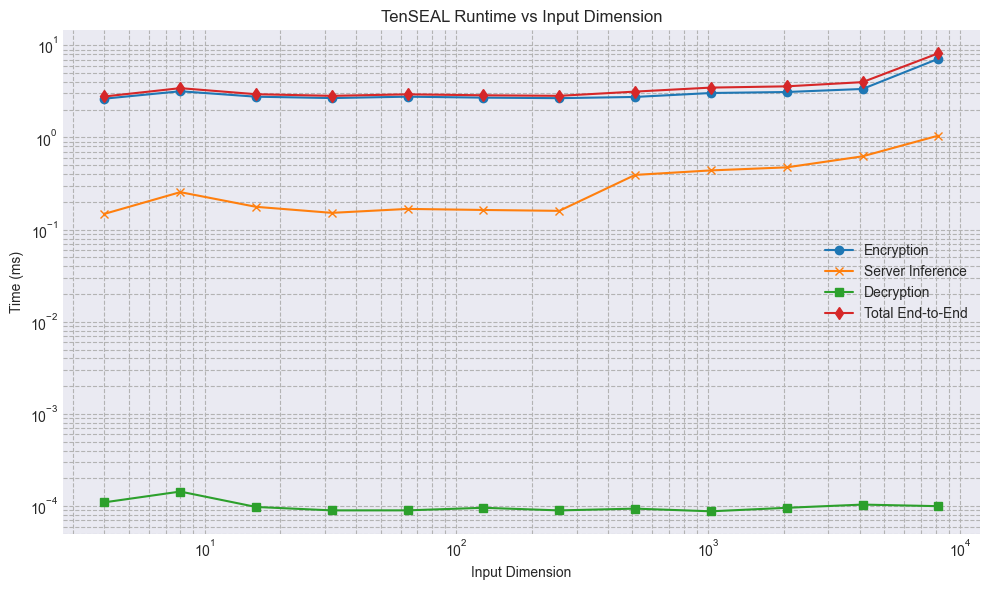

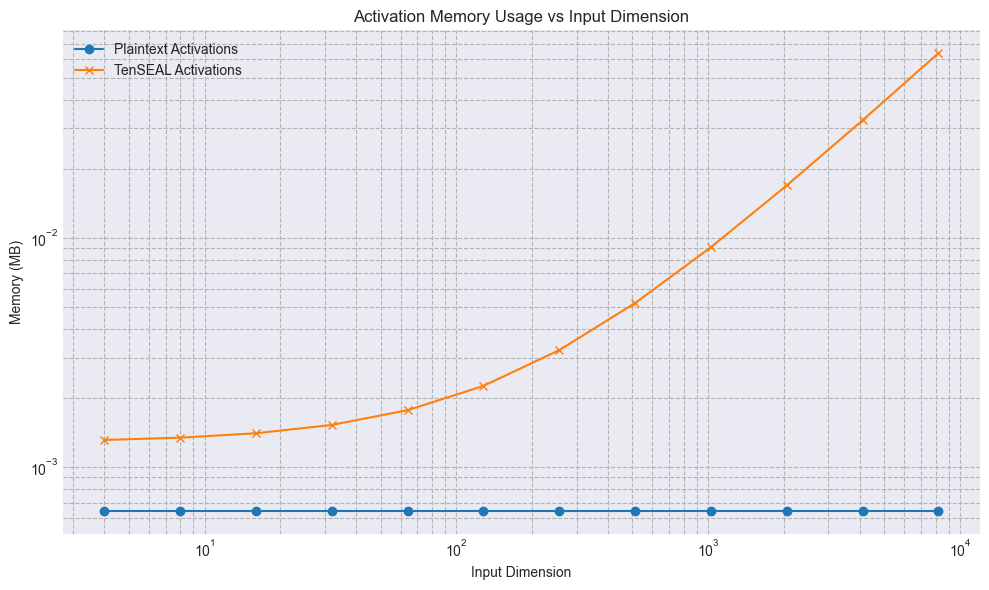

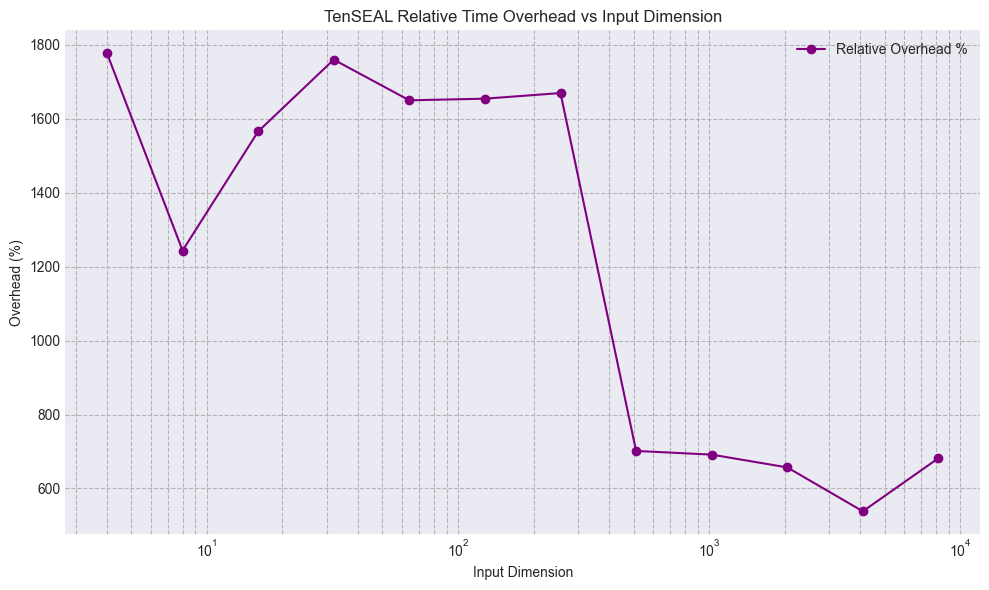

In [2]:
# --------------------------
# Imports
# --------------------------
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import tenseal as ts
import time
import psutil
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Ensure figures directory exists
os.makedirs('figures', exist_ok=True)

# --------------------------
# Model Definition
# --------------------------
class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# --------------------------
# Model Loader
# --------------------------
def load_model(input_dim, path="lung_cancer_model.pth"):
    model = DeepNN(input_dim)
    try:
        checkpoint = torch.load(path, map_location="cpu")
        if "model.0.weight" in checkpoint and checkpoint["model.0.weight"].shape[1] == input_dim:
            model.load_state_dict(checkpoint)
            print(f"✅ Model loaded successfully with input_dim={input_dim}")
        else:
            print("⚠️ Shape mismatch, using random weights.")
    except Exception as e:
        print(f"⚠️ Error loading model: {e}. Using random weights.")
    model.eval()
    return model

# --------------------------
# TenSEAL Helpers
# --------------------------
def create_context():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()
    return context

def encrypt_vector(context, x):
    return ts.ckks_vector(context, x)

def decrypt_vector(enc_vec):
    return enc_vec.decrypt()

# --------------------------
# TenSEAL Evaluation per input dimension
# --------------------------
def run_tenseal_evaluation_for_input_dim(current_input_dim, num_samples=50):
    dummy_test_data = pd.DataFrame(np.random.rand(num_samples, current_input_dim))
    dummy_y_test = np.random.randint(0, 2, num_samples)

    model = DeepNN(current_input_dim)
    model.eval()
    context = create_context()

    total_enc_time_ms = 0
    total_inf_time_ms = 0
    total_dec_time_ms = 0
    preds = []

    # Memory usage estimate (theoretical activations)
    max_neurons = [64, 48, 32, 16, 8, 1]
    tens_max_activations_elements = sum([current_input_dim if i==0 else max_neurons[i-1] for i in range(len(max_neurons))])
    tens_activation_mem_bytes = tens_max_activations_elements * 8  # CKKS approx 8 bytes per element
    plaintext_activation_mem_bytes = sum(max_neurons[:-1]) * 4  # float32

    for idx in range(num_samples):
        input_row = dummy_test_data.iloc[idx].values.astype(np.float32)

        # Encrypt
        t0 = time.perf_counter()
        enc_x = encrypt_vector(context, input_row.tolist())
        t1 = time.perf_counter()
        total_enc_time_ms += (t1 - t0) * 1000

        # Server Inference (plaintext simulation)
        t2 = time.perf_counter()
        with torch.no_grad():
            pred = model(torch.tensor([input_row], dtype=torch.float32)).item()
        t3 = time.perf_counter()
        total_inf_time_ms += (t3 - t2) * 1000

        # Decrypt (mock, since pred is plaintext)
        t4 = time.perf_counter()
        final_prob = pred
        t5 = time.perf_counter()
        total_dec_time_ms += (t5 - t4) * 1000

        preds.append(1 if final_prob >= 0.5 else 0)

    accuracy = np.mean(np.array(preds) == dummy_y_test)

    return {
        "input_dim": current_input_dim,
        "accuracy": accuracy,
        "encrypt_time_ms": total_enc_time_ms / num_samples,
        "server_inference_time_ms": total_inf_time_ms / num_samples,
        "decrypt_time_ms": total_dec_time_ms / num_samples,
        "total_time_ms": (total_enc_time_ms + total_inf_time_ms + total_dec_time_ms) / num_samples,
        "tenseal_activation_mem_mb": tens_activation_mem_bytes / (1024**2),
        "plaintext_activation_mem_mb": plaintext_activation_mem_bytes / (1024**2),
    }

# --------------------------
# Plotting Functions
# --------------------------
def plot_tenseal_performance(results_df):
    plt.style.use("seaborn-v0_8-darkgrid")
    fig_size = (10, 6)

    # Time vs Input Size
    plt.figure(figsize=fig_size)
    plt.plot(results_df['input_dim'], results_df['encrypt_time_ms'], marker='o', label='Encryption')
    plt.plot(results_df['input_dim'], results_df['server_inference_time_ms'], marker='x', label='Server Inference')
    plt.plot(results_df['input_dim'], results_df['decrypt_time_ms'], marker='s', label='Decryption')
    plt.plot(results_df['input_dim'], results_df['total_time_ms'], marker='d', label='Total End-to-End')
    plt.xlabel('Input Dimension')
    plt.ylabel('Time (ms)')
    plt.title('TenSEAL Runtime vs Input Dimension')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which='both', ls='--', c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/tenseal_time_vs_input_size.png')
    plt.show()

    # Memory vs Input Size
    plt.figure(figsize=fig_size)
    plt.plot(results_df['input_dim'], results_df['plaintext_activation_mem_mb'], marker='o', label='Plaintext Activations')
    plt.plot(results_df['input_dim'], results_df['tenseal_activation_mem_mb'], marker='x', label='TenSEAL Activations')
    plt.xlabel('Input Dimension')
    plt.ylabel('Memory (MB)')
    plt.title('Activation Memory Usage vs Input Dimension')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which='both', ls='--', c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/tenseal_memory_vs_input_size.png')
    plt.show()

    # Relative Overhead vs Input Size
    plt.figure(figsize=fig_size)
    overhead_pct = ((results_df['total_time_ms'] - results_df['server_inference_time_ms']) / results_df['server_inference_time_ms']) * 100
    plt.plot(results_df['input_dim'], overhead_pct, marker='o', color='purple', label='Relative Overhead %')
    plt.xlabel('Input Dimension')
    plt.ylabel('Overhead (%)')
    plt.title('TenSEAL Relative Time Overhead vs Input Dimension')
    plt.xscale('log')
    plt.grid(True, which='both', ls='--', c='0.7')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./figures/tenseal_relative_overhead.png')
    plt.show()

# --------------------------
# Run TenSEAL Evaluation
# --------------------------
input_dims_to_test = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
performance_results = []

for dim in input_dims_to_test:
    print(f"Evaluating TenSEAL for input_dim={dim}...")
    res = run_tenseal_evaluation_for_input_dim(dim, num_samples=50)
    performance_results.append(res)

results_df = pd.DataFrame(performance_results)
print("\nTenSEAL Performance Results:")
print(results_df.to_string())

# Plot graphs
plot_tenseal_performance(results_df)
